In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import ttest_ind

from matplotlib import pyplot as plt
import seaborn as sns

Trying to set attribute `.uns` of view, copying.


View of AnnData object with n_obs × n_vars = 1910 × 26894
    obs: 'sample_type', 'sc_cluster', 'csplotch_annot', 'n_counts', 'log_counts', 'n_genes'


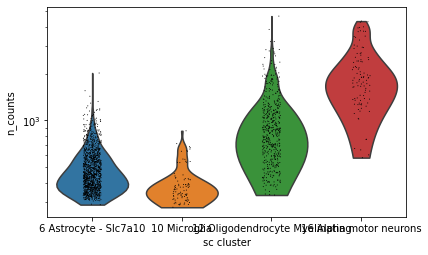

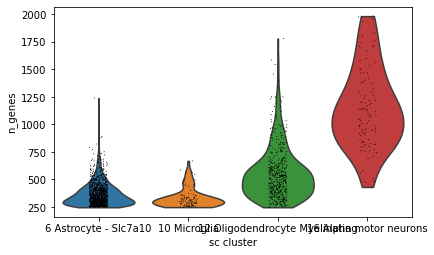

In [31]:
cells_file = '../data/GSM3017261_20000_SC_nuclei.h5ad'
adat = sc.read_h5ad(cells_file)
#sc.pp.normalize_total(adat, target_sum=1000)  # scale all cells to have 1000 total UMIs

# Quality control - calculate QC covariates
adat.obs['n_counts'] = adat.X.sum(1)
adat.obs['log_counts'] = np.log(adat.obs['n_counts'])
adat.obs['n_genes'] = (adat.X > 0).sum(1)

selected_profiles = [
    '6 Astrocyte - Slc7a10',
    '10 Microglia',
    '12 Oligodendrocyte Myelinating',
    '16 Alpha motor neurons'
]
adat4 = adat[adat.obs['sc_cluster'].isin(selected_profiles)]

sc.pl.violin(adat4, 'n_counts', groupby='sc_cluster', log=True)
sc.pl.violin(adat4, 'n_genes', groupby='sc_cluster')

6 Astrocyte - Slc7a10 289.0 2015.0
10 Microglia 278.0 859.0
12 Oligodendrocyte Myelinating 333.0 4666.0
16 Alpha motor neurons 578.0 4335.0


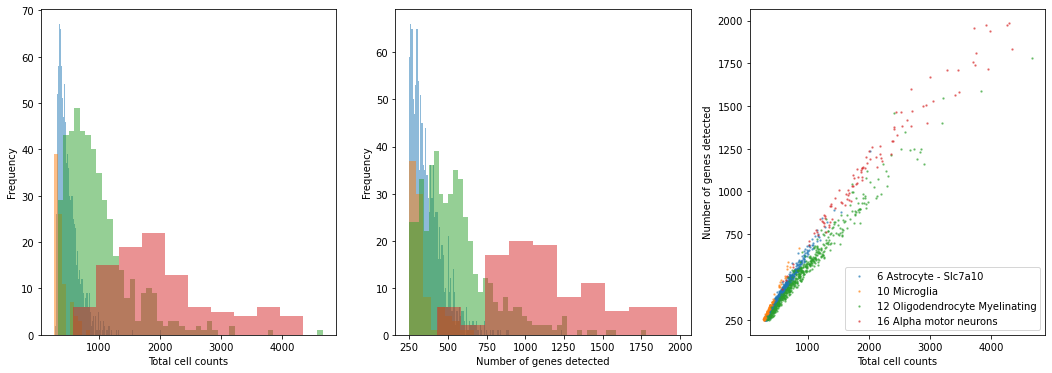

In [32]:
# To see if we should be normalizing counts per cell, what is the distribution over total counts per type?
adata_cells = adat4
celltype_label = 'sc_cluster'

fig, ax = plt.subplots(1,3, figsize=(18,6))

for i,ct in enumerate(selected_profiles):
    cells_in = adata_cells[adata_cells.obs[celltype_label] == ct]
    cell_counts = cells_in.X.sum(axis=1)
    cell_counts = np.squeeze(np.array(cell_counts))
    
    print(ct, cell_counts.min(), cell_counts.max())
        
    # Total counts per cell
    ax[0].hist(cell_counts, bins=int(len(cell_counts)/10), label=ct, alpha=0.5)

    gene_counts = (cells_in.X > 0).sum(axis=1)
    gene_counts = np.squeeze(np.array(gene_counts))
    
    # Unique genes per cell
    ax[1].hist(gene_counts, bins=int(len(gene_counts)/10), label=ct, alpha=0.5)
    
    # Scatter total counts (cell depth) against # unique genes
    ax[2].scatter(cell_counts, gene_counts, label=ct, alpha=0.5, s=2)

ax[0].set_xlabel('Total cell counts')
ax[0].set_ylabel('Frequency')

ax[1].set_xlabel('Number of genes detected')
ax[1].set_ylabel('Frequency')

ax[2].set_xlabel('Total cell counts')
ax[2].set_ylabel('Number of genes detected')

plt.legend()
plt.show()

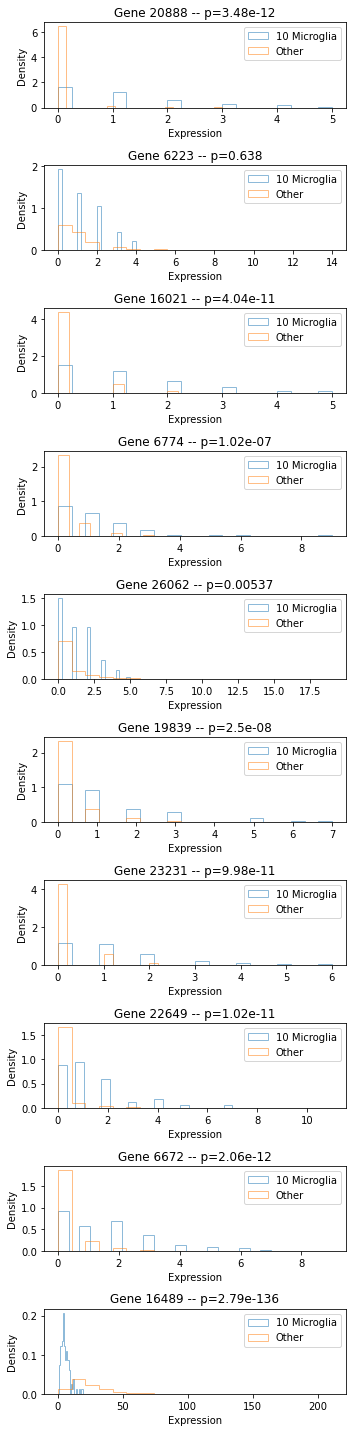

In [7]:
# SINCERA (Guo et al. 2015) seems to use Welch's t-test between cells_in and cells_out (prior to normalizaion)
# in order to detect DE genes.
# -> Is this sensible given the likelihood of cells_out being multimodal?

ct = '10 Microglia'
cells_in = adata_cells[adata_cells.obs[celltype_label] == ct]
cells_out = adata_cells[adata_cells.obs[celltype_label] != ct]

# Choose 10 most highly expressed genes within the group
counts_per_gene = np.squeeze(np.array(cells_in.X.sum(axis=0)))
genes = counts_per_gene.argsort()[-10:]
    
fig = plt.figure(figsize=(5, 2*len(genes)))
for i,g in enumerate(genes):
    ax = fig.add_subplot(len(genes), 1, i+1)
    
    expr_in = np.array(cells_in[:,g].X.todense()).squeeze()
    expr_out = np.array(cells_out[:,g].X.todense()).squeeze()
    
    # Two-sample t-test between raw counts from each group
    _,p = ttest_ind(expr_in, expr_out, equal_var=False)
            
    ax.hist(expr_in, bins=20, alpha=0.5, density=True, histtype='step', label=ct)
    ax.hist(expr_out, bins=20, alpha=0.5, density=True, histtype='step', label='Other')
    ax.set_title('Gene %d -- p=%.3g' % (g, p))
    ax.set_xlabel('Expression')
    ax.set_ylabel('Density')
    ax.legend()
        
plt.tight_layout()
plt.show()

In [8]:
# Try cell-level normalization using scran R package
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [33]:
# Prepare input to scran
input_groups = adata_cells.obs['sc_cluster']  # scran requires an initial clustering to improve size factor estimation

data_mat = adata_cells.X.toarray().T  # Scanpy expects (cells x genes), R platforms expect the opposite.

In [22]:
%%R -i data_mat -i input_groups -o size_factors

library(scran)

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

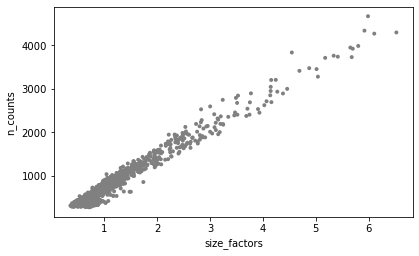

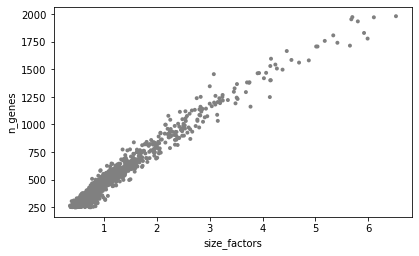

/Users/adaly/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


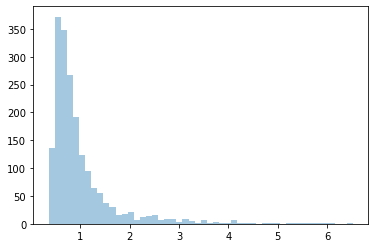

In [34]:
# Visualize the estimated size factors, which are non-negative and proportional to # of gene and counts in each cell
adata_cells.obs['size_factors'] = size_factors

sc.pl.scatter(adata_cells, 'size_factors', 'n_counts')
sc.pl.scatter(adata_cells, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

In [38]:
# Normalize counts, but maintain copy of the raw counts
adata_cells.layers["counts"] = adata_cells.X.copy()
adata_cells.X /= adata_cells.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_cells)  # Log transform with an offset of 1
adata_cells.raw = adata_cells

(array([  6.,   3.,   3.,   3.,  10.,  10.,   9.,  12.,   7.,  18.,  25.,
         36.,  53.,  88.,  74.,  98., 107., 104., 121.,  93.,  94.,  99.,
         88.,  87.,  90.,  75.,  66.,  50.,  61.,  46.,  48.,  30.,  28.,
         21.,  22.,  25.,  23.,  17.,  12.,  14.,   8.,  11.,   7.,   1.,
          2.,   0.,   2.,   0.,   2.,   1.]),
 array([227.32819557, 234.19186692, 241.05553827, 247.91920962,
        254.78288098, 261.64655233, 268.51022368, 275.37389503,
        282.23756639, 289.10123774, 295.96490909, 302.82858044,
        309.6922518 , 316.55592315, 323.4195945 , 330.28326585,
        337.14693721, 344.01060856, 350.87427991, 357.73795126,
        364.60162262, 371.46529397, 378.32896532, 385.19263667,
        392.05630803, 398.91997938, 405.78365073, 412.64732208,
        419.51099344, 426.37466479, 433.23833614, 440.10200749,
        446.96567885, 453.8293502 , 460.69302155, 467.5566929 ,
        474.42036426, 481.28403561, 488.14770696, 495.01137831,
        501.875049

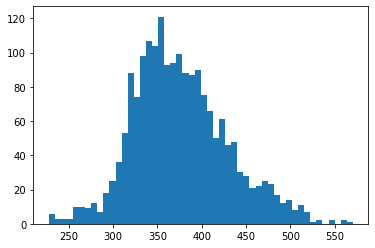

In [41]:
plt.hist(adata_cells.X.sum(axis=1), bins=50)